In [19]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import os
import cv2
import numpy as np
import wavemix.sisr as sisr
from torchinfo import summary

In [5]:
BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
data_path = Path.cwd() / "data"

train_data_folder = data_path/"DIV2K/DIV2K_train_LR_bicubic/X2"
test_data_folder = data_path/"DIV2K/DIV2K_valid_LR_bicubic/X2"

train_data_targest_folder = data_path/"DIV2K/DIV2K_train_HR"
test_data_targest_folder = data_path/"DIV2K/DIV2K_valid_HR"

In [7]:
# Custom class for loading data

class CustomDataSet(Dataset):
    def __init__(self, lr_image_folder, hr_image_folder, transform=None):
        self.lr_image_folder = lr_image_folder
        self.hr_image_folder = hr_image_folder
        self.lr_image_files = os.listdir(lr_image_folder)
        self.hr_image_files = os.listdir(hr_image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.lr_image_files)
    
    def __getitem__(self, idx):
        lr_image = cv2.cvtColor(cv2.imread(str(self.lr_image_folder/self.lr_image_files[idx])), cv2.COLOR_BGR2YCrCb)
        hr_image = cv2.cvtColor(cv2.imread(str(self.hr_image_folder/self.hr_image_files[idx])), cv2.COLOR_BGR2YCrCb)
        lr_image = torch.tensor(lr_image).permute(2, 0, 1).float() # Since OpenCV represents images as HWC and Pytorch expects them as CHW
        hr_image = torch.tensor(hr_image).permute(2, 0, 1).float()
        return lr_image, hr_image

Number of training samples: 800


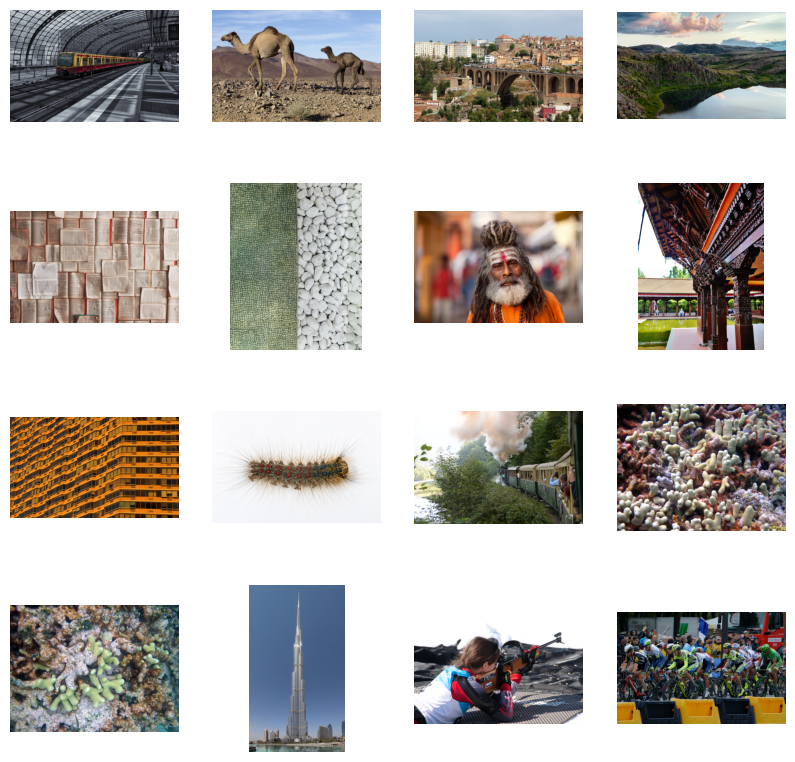

In [8]:
# Visualize random data

train_dataset = CustomDataSet(lr_image_folder=train_data_folder, 
                              hr_image_folder=train_data_targest_folder,
                              )
test_dataset = CustomDataSet(lr_image_folder=test_data_folder,
                             hr_image_folder=test_data_targest_folder)

# Plot random images
print(f"Number of training samples: {len(train_dataset)}")
random_indices = random.sample(range(len(train_dataset)), 16)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img = train_dataset[idx][0]
    ax = axs[i//4, i%4]
    ax.imshow(cv2.cvtColor(np.asarray(img.permute(1,2,0).type(torch.uint8)), cv2.COLOR_YCrCb2RGB))
    ax.axis("off")
plt.show()

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
class WaveMixSR(nn.Module):
    def __init__(
        self,
        *,
        depth,
        mult = 1,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.3,
        scale_factor = 2
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(sisr.Level1Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))
        
        self.final = nn.Sequential(
            nn.Conv2d(final_dim,int(final_dim/2), 3, stride=1, padding=1),
            nn.Conv2d(int(final_dim/2), 1, 1)
        )


        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners = False),
            nn.Conv2d(1, int(final_dim/2), 3, 1, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 1, 1)
        )

        self.path2 = nn.Sequential(
            nn.Upsample(scale_factor=int(scale_factor), mode='bilinear', align_corners = False),
        )

    def forward(self, img):

        y = img[:, 0:1, :, :] 
        crcb = img[:, 1:3, :, :]

        y = self.path1(y)


        for attn in self.layers:
            y = attn(y) + y

        y = self.final(y)

        crcb = self.path2(crcb)
        
        return  torch.cat((y,crcb), dim=1)



In [21]:
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.3,
    scale_factor=2
)
model.to(DEVICE)
print(summary(model, input_size=(BATCH_SIZE, 3, 1000, 1000), verbose=0))


# image = next(iter(train_loader))[0].to(DEVICE)
# print(image.shape)

# output = model(image)
# print(output.shape)

Layer (type:depth-idx)                        Output Shape              Param #
WaveMixSR                                     [1, 3, 2000, 2000]        --
├─Sequential: 1-1                             [1, 144, 2000, 2000]      --
│    └─Upsample: 2-1                          [1, 1, 2000, 2000]        --
│    └─Conv2d: 2-2                            [1, 72, 2000, 2000]       720
│    └─Conv2d: 2-3                            [1, 144, 2000, 2000]      93,456
├─ModuleList: 1-2                             --                        --
│    └─Level1Waveblock: 2-4                   [1, 144, 2000, 2000]      --
│    │    └─Conv2d: 3-1                       [1, 36, 2000, 2000]       5,220
│    │    └─Sequential: 3-2                   [1, 144, 2000, 2000]      373,968
│    └─Level1Waveblock: 2-5                   [1, 144, 2000, 2000]      --
│    │    └─Conv2d: 3-3                       [1, 36, 2000, 2000]       5,220
│    │    └─Sequential: 3-4                   [1, 144, 2000, 2000]      373,968